# Class Workbook

## In class activity

In [1]:
import numpy as np
import pandas as pd
import math
#import statsmodels.api as sm
from plotnine import *
import statsmodels.formula.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                        summarize ,
                        poly)

### Ames House Data

In [2]:
ames_raw=pd.read_csv("ames_raw.csv")

Let's revisit the AmesHousing data.  As we did in the previous class, I will split the data into before 2008 and after.  The data up to 2008 will be the training data and after 2008 will be the testing data.

In [3]:
ames_raw_2009, ames_raw_2008= ames_raw.query('`Yr Sold`>=2008').copy(), ames_raw.query('`Yr Sold` <2008').copy()

* For the regression model fit, use bootstrap to compare the standard error estimates to the model based estimates.


Your code:

In [4]:
formula = "np.log(SalePrice) ~ Q('Year Built') + Q('Year Remod/Add') + Q('Total Bsmt SF') + Q('1st Flr SF') + Q('Gr Liv Area') + Q('Full Bath') + Q('TotRms AbvGrd') + Q('Garage Area') + Q('Year Built'):Q('Year Remod/Add') + Q('Total Bsmt SF'):Q('1st Flr SF') + Q('Gr Liv Area'):Q('TotRms AbvGrd') + Q('Garage Area'):Q('Year Built')"
lmfit_2008 =  sm.ols(formula, data = ames_raw_2008).fit() # use ames_raw_2008
print(lmfit_2008.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     506.8
Date:                Sat, 03 Feb 2024   Prob (F-statistic):               0.00
Time:                        13:10:19   Log-Likelihood:                 475.56
No. Observations:                1318   AIC:                            -925.1
Df Residuals:                    1305   BIC:                            -857.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [5]:
def bootstrap_se(df, n_bootstraps=1000):
    bootstraps_se = []
    np.random.seed(42)
    
    for _ in range(n_bootstraps):
        # Sample with replacement
        sample = df.sample(n=len(df), replace=True)
        
        # Fit the model on the bootstrap sample
        model = sm.ols(formula, data=sample).fit()
        
        # Store the standard errors of the coefficients
        bootstraps_se.append(model.bse)
    
    return pd.DataFrame(bootstraps_se)

# Perform bootstrapping
bootstraps_se = bootstrap_se(ames_raw_2009)

# Calculate the standard errors from the bootstrap samples
bootstrap_standard_errors = bootstraps_se.std()

print("Bootstrap Standard Errors:")
print(bootstrap_standard_errors)

Bootstrap Standard Errors:
Intercept                              2.159540e+00
Q('Year Built')                        1.106017e-03
Q('Year Remod/Add')                    1.090821e-03
Q('Total Bsmt SF')                     4.771165e-06
Q('1st Flr SF')                        4.104099e-06
Q('Gr Liv Area')                       2.514337e-06
Q('Full Bath')                         7.133023e-04
Q('TotRms AbvGrd')                     6.163576e-04
Q('Garage Area')                       9.441318e-05
Q('Year Built'):Q('Year Remod/Add')    5.586422e-07
Q('Total Bsmt SF'):Q('1st Flr SF')     5.069290e-09
Q('Gr Liv Area'):Q('TotRms AbvGrd')    3.517164e-07
Q('Garage Area'):Q('Year Built')       4.800036e-08
dtype: float64


Your answer:

~~~
Bootstrap standard errors are generally smaller than model-based errors, suggesting a more optimistic assessment of coefficient precision from the bootstrap method.
~~~


* Use cross validation  to decide which model has a good predictive accuracy.  Does the result hold true for the prediction of future data?

Your code:

In [9]:
from sklearn.model_selection import KFold
import statsmodels.formula.api as sm
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_model1 = []
mse_model2 = []

for train_index, test_index in kf.split(ames_raw_2008):
    train_data, test_data = ames_raw_2008.iloc[train_index], ames_raw_2008.iloc[test_index]
    
    # Model 1
    formula1 = "np.log(SalePrice) ~ Q('Year Built') + Q('Year Remod/Add') + Q('Total Bsmt SF') + Q('1st Flr SF') + Q('Gr Liv Area') + Q('Full Bath') + Q('TotRms AbvGrd') + Q('Garage Area')"
    model1 = sm.ols(formula1, data=train_data).fit()
    predictions1 = model1.predict(test_data)
    predictions1 = predictions1.fillna(predictions1.mean())
    mse_model1.append(mean_squared_error(np.log(test_data['SalePrice']), predictions1))
    
    # Model 2
    formula2 = "np.log(SalePrice) ~ Q('Year Built') + Q('Year Remod/Add') + Q('Total Bsmt SF') + Q('1st Flr SF') + Q('Gr Liv Area') + Q('Full Bath') + Q('TotRms AbvGrd') + Q('Garage Area') + Q('Year Built'):Q('Year Remod/Add') + Q('Total Bsmt SF'):Q('1st Flr SF') + Q('Gr Liv Area'):Q('TotRms AbvGrd') + Q('Garage Area'):Q('Year Built')"
    model2 = sm.ols(formula2, data=train_data).fit()
    predictions2 = model2.predict(test_data)
    predictions2 = predictions2.fillna(predictions2.mean())
    mse_model2.append(mean_squared_error(np.log(test_data['SalePrice']), predictions2))

# 计算平均 MSE
avg_mse_model1 = np.mean(mse_model1)
avg_mse_model2 = np.mean(mse_model2)

print(f"Model 1 Average MSE: {avg_mse_model1}")
print(f"Model 2 Average MSE: {avg_mse_model2}")

Model 1 Average MSE: 0.036111120652910875
Model 2 Average MSE: 0.029709499319593526


Your answer:

~~~
Based on the average MSE, model2 which has interaction terms performs better. This is also true for the test data.
~~~


* Using `knn.reg` fit KNN regression model.  Use cross validation to decide which K to use.

Your code:

In [39]:
ames_raw=pd.read_csv("ames_raw.csv")
ames_raw_2009, ames_raw_2008= ames_raw.query('`Yr Sold`>=2008').copy(), ames_raw.query('`Yr Sold` <2008').copy()

In [44]:
X_train = ames_raw_2008[['Year Built', 'Year Remod/Add', 'Total Bsmt SF', '1st Flr SF', 
                      'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Garage Area']].dropna()
y_train = np.log(ames_raw_2008['SalePrice']).loc[X_train.index]  # Match the labels with the filtered rows
X_test = ames_raw_2009[['Year Built', 'Year Remod/Add', 'Total Bsmt SF', '1st Flr SF', 
                      'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Garage Area']].dropna()
y_test = np.log(ames_raw_2009['SalePrice']).loc[X_test.index]  # Match the labels with the filtered rows

In [45]:
print(X_train.shape)  # Check the number of rows and columns in X_train
print(y_train.shape)  # Check the number of rows in y_train


(1318, 8)
(1318,)


In [46]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# KNN
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(1, 31)}

# GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'n_neighbors': 12}


Your answer:

~~~
Best K = 12.
~~~


* Which model performs better on your training data?  Which model performs better in your future prediction?

Your code:

In [51]:
# Split again
X_train = ames_raw_2008.drop(columns=['SalePrice'])
y_train = np.log(ames_raw_2008['SalePrice'])
X_test = ames_raw_2009.drop(columns=['SalePrice'])
y_test = np.log(ames_raw_2009['SalePrice'])

# Model 1
model1 = sm.ols(formula1, data=ames_raw_2008).fit()
train_predictions1 = model1.predict(X_train)
train_predictions1 = train_predictions1.fillna(train_predictions1.mean())
test_predictions1 = model1.predict(X_test)
test_predictions1 = test_predictions1.fillna(test_predictions1.mean())

# Model 1 MSE
train_mse_model1 = mean_squared_error(y_train, train_predictions1)
test_mse_model1 = mean_squared_error(y_test, test_predictions1)

# Model 2
model2 = sm.ols(formula2, data=ames_raw_2008).fit()
train_predictions2 = model2.predict(X_train)
train_predictions2 = train_predictions2.fillna(train_predictions2.mean())
test_predictions2 = model2.predict(X_test)
test_predictions2 = test_predictions2.fillna(test_predictions2.mean())

# Model 2 MSE
train_mse_model2 = mean_squared_error(y_train, train_predictions2)
test_mse_model2 = mean_squared_error(y_test, test_predictions2)

print(f"Model 1 Train MSE: {train_mse_model1}")
print(f"Model 1 Test MSE: {test_mse_model1}")
print(f"Model 2 Train MSE: {train_mse_model2}")
print(f"Model 2 Test MSE: {test_mse_model2}")

Model 1 Train MSE: 0.03473977799856296
Model 1 Test MSE: 0.039508522888133044
Model 2 Train MSE: 0.028440592361156397
Model 2 Test MSE: 0.03392795358838713


In [48]:
# KNN with best parameter
best_knn = KNeighborsRegressor(n_neighbors=grid_search.best_params_['n_neighbors'])
best_knn.fit(X_train, y_train)

train_predictions = best_knn.predict(X_train)
test_predictions = best_knn.predict(X_test)

# Train MSE
train_mse = mean_squared_error(y_train, train_predictions)
print(f"Train MSE: {train_mse}")

# Test MSE
test_mse = mean_squared_error(y_test, test_predictions)
print(f"Test MSE: {test_mse}")

Train MSE: 0.035024248033121826
Test MSE: 0.047903293649576184


Your answer:

~~~
Model 1 Train MSE: 0.03473977799856296
Model 1 Test MSE: 0.039508522888133044
Model 2 Train MSE: 0.028440592361156397
Model 2 Test MSE: 0.03392795358838713
KNN Train MSE: 0.035024248033121826
KNN Test MSE: 0.047903293649576184
Therefore, Model 2 (Linear regression with interaction terms) performs better on both train and test set.
~~~

## Problem Set

### Bootstrap

We will now investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We first create an array store with values that will subsequently
be overwritten using the function np.empty(). We then repeatedly create bootstrap samples, and each time we record whether or not the fifth observation is contained in the bootstrap
sample.

We will investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We repeatedly create bootstrap samples, and each time
we record whether or not the fourth observation is contained in the bootstrap sample.

Here is the code to get you going

In [52]:
rng = np.random.default_rng (10)
store = np.empty (10000)
for i in range (10000):
    store[i] = np.sum(rng.choice(100, 100, replace=True) == 4) > 0


np.mean(store)

0.6362

Comment on the results obtained.


Your code:

Your answer:

~~~
Although the bootstrap sample is obtained from the original sample by replacement, each observation is equally likely to be selected in each sample, but not every observation will appear in every bootstrap sample.
The code shows that the probability that bootstrap sample contains certain value is 63.62%. That's in line with the mathematical calcualtion: lim(n->infinity)(1-(1/n)^n)=0.63.

~~~

### CV

We will now perform cross-validation on a simulated data set.
(a) Generate a simulated data set as follows:

In [53]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

In this data set, what is n and what is p? Write out the model
used to generate the data in equation form.


Your code:

Your answer:

~~~
n = 100, p = 2.
y = β0 + β1x + β2x^2 +error = x - 2x^2 + error
~~~


(b) Create a scatterplot of X against Y . Comment on what you find.


Your code:

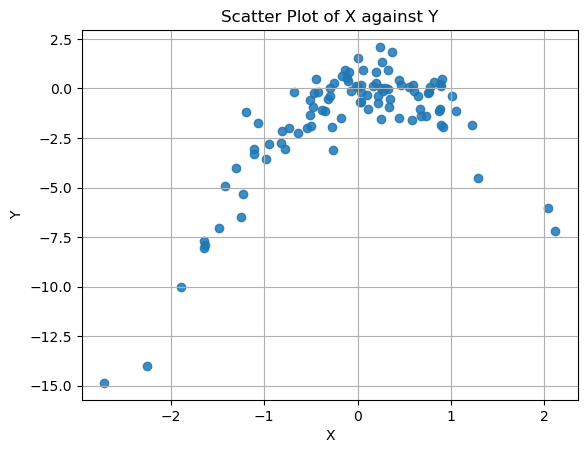

In [59]:
import matplotlib.pyplot as plt

# Scatterplot
plt.scatter(x, y, alpha = 0.85)
plt.title("Scatter Plot of X against Y")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

Your answer:

~~~
The plot shows the distribution is along y = x - 2x^2.
~~~

(c) Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:

i.   $Y = \beta_0 + \beta_1X + \epsilon$
ii.  $Y = \beta_0 + \beta_1X + \beta_2X^2 + \epsilon$
iii. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$
iv.  $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \beta_4X^4 + \epsilon$.

Note you may find it helpful to use the `data.frame()` function
to create a single data set containing both $X$ and $Y$ .


Your code:

In [61]:
import statsmodels.api as sm
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

# Set random seed
np.random.seed(100)

# Generate data
x = np.random.normal(size=100)
y = x - 2 * x**2 + np.random.normal(size=100)
X = np.vstack([x, x**2, x**3, x**4]).T

# Create DataFrame
df = pd.DataFrame(X, columns=['X', 'X2', 'X3', 'X4'])
df['Y'] = y

# LOOCV
loo = LeaveOneOut()
models = ['Y ~ X', 'Y ~ X + X2', 'Y ~ X + X2 + X3', 'Y ~ X + X2 + X3 + X4']
loocv_mse = []

for model_formula in models:
    mse_list = []
    for train_index, test_index in loo.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]
        model = sm.OLS.from_formula(model_formula, data=train).fit()
        y_pred = model.predict(test)
        # Calculate MSE
        mse = mean_squared_error(test['Y'], y_pred)
        mse_list.append(mse)
    # Average MSE
    loocv_mse.append(np.mean(mse_list))

for i, mse in enumerate(loocv_mse, start=1):
    print(f"Model {i} LOOCV MSE: {mse}")

Model 1 LOOCV MSE: 5.772817045970774
Model 2 LOOCV MSE: 1.1563879346405441
Model 3 LOOCV MSE: 1.1903554702081685
Model 4 LOOCV MSE: 1.1865709751492126


Your answer:

~~~
Please write your answer in full sentences.


~~~


(d) Repeat (c) using another random seed, and report your results.
Are your results the same as what you got in (c)? Why?

Your code:

In [62]:
# Set random seed
np.random.seed(1)

# Generate data
x = np.random.normal(size=100)
y = x - 2 * x**2 + np.random.normal(size=100)
X = np.vstack([x, x**2, x**3, x**4]).T

# Create DataFrame
df = pd.DataFrame(X, columns=['X', 'X2', 'X3', 'X4'])
df['Y'] = y

# LOOCV
loo = LeaveOneOut()
models = ['Y ~ X', 'Y ~ X + X2', 'Y ~ X + X2 + X3', 'Y ~ X + X2 + X3 + X4']
loocv_mse = []

for model_formula in models:
    mse_list = []
    for train_index, test_index in loo.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]
        model = sm.OLS.from_formula(model_formula, data=train).fit()
        y_pred = model.predict(test)
        # Calculate MSE
        mse = mean_squared_error(test['Y'], y_pred)
        mse_list.append(mse)
    # Average MSE
    loocv_mse.append(np.mean(mse_list))

for i, mse in enumerate(loocv_mse, start=1):
    print(f"Model {i} LOOCV MSE: {mse}")

Model 1 LOOCV MSE: 6.260764331604614
Model 2 LOOCV MSE: 0.9142897072803663
Model 3 LOOCV MSE: 0.9268768781648802
Model 4 LOOCV MSE: 0.8669116865881081


Your answer:

~~~
The results are different. I think the difference is due to the change in samples. Because the n = 100, which is a quite small sample size, we would expect high variance between different samples.
~~~

(e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.

Your code:

Your answer:

~~~
Model 2 has the smallest LOOCV error, which is in line with my expectation because the true distribution is also a second-order polynomial.
~~~


(f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?


Your code:

In [71]:
import statsmodels.formula.api as sm

# Set random seed
np.random.seed(100)

# Generate data
x = np.random.normal(size=100)
y = x - 2 * x**2 + np.random.normal(size=100)
X = np.vstack([x, x**2, x**3, x**4]).T

# Create DataFrame
df = pd.DataFrame(X, columns=['X', 'X2', 'X3', 'X4'])
df['Y'] = y

# Define models
models = ['Y ~ X', 'Y ~ X + X2', 'Y ~ X + X2 + X3', 'Y ~ X + X2 + X3 + X4']

# Fit models and print coefficients and p-values
for model_formula in models[:2]:
    model = sm.ols(model_formula, data=df).fit()
    print(f"{model_formula} Coefficients and P-values:")
    print(model.summary().tables[1])
    print("\n")

Y ~ X Coefficients and P-values:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9443      0.235     -8.263      0.000      -2.411      -1.477
X              1.2736      0.241      5.279      0.000       0.795       1.752


Y ~ X + X2 Coefficients and P-values:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2005      0.139     -1.444      0.152      -0.476       0.075
X              0.8496      0.111      7.641      0.000       0.629       1.070
X2            -1.8796      0.096    -19.560      0.000      -2.070      -1.689




In [72]:
# Fit models and print coefficients and p-values
for model_formula in models[2:4]:
    model = sm.ols(model_formula, data=df).fit()
    print(f"{model_formula} Coefficients and P-values:")
    print(model.summary().tables[1])  # Print the summary table of coefficients and p-values
    print("\n")

Y ~ X + X2 + X3 Coefficients and P-values:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2021      0.141     -1.436      0.154      -0.482       0.077
X              0.8351      0.201      4.149      0.000       0.436       1.235
X2            -1.8773      0.100    -18.743      0.000      -2.076      -1.678
X3             0.0066      0.076      0.086      0.931      -0.145       0.158


Y ~ X + X2 + X3 + X4 Coefficients and P-values:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1170      0.163     -0.716      0.476      -0.441       0.207
X              0.7462      0.219      3.405      0.001       0.311       1.181
X2            -2.1014      0.241     -8.736      0.000      -2.579      -1.624
X3             0.0515      0.088      

Your answer:

~~~
The p-value of X3 and X4 is greater than 0.05, which means their coefficients are not statistical significance. Therefore, we can reject the Null and say the coefficicents of X3 and X4 is 0. This is in line with the cross-validation results that Model 2 is the optimal model.
~~~

### Default 1

In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the `Default` data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

(a) Fit a logistic regression model that uses income and balance to predict default.

Your code:

In [74]:
from ISLP import load_data
default = load_data('Default')
default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [75]:
default.columns

Index(['default', 'student', 'balance', 'income'], dtype='object')

In [80]:
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Use LabelEncoder to binarize the 'default' column
label_encoder = LabelEncoder()
default['default'] = label_encoder.fit_transform(default['default'])

# Prepare the data
X = default[['balance', 'income']]
y = default['default']

# Set a random seed
np.random.seed(100)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Fit the logistic regression model using statsmodels
logit_fit = sm.Logit(y_train, X_train).fit()

print(logit_fit.summary())

Optimization terminated successfully.
         Current function value: 0.180484
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6998
Method:                           MLE   Df Model:                            1
Date:                Sat, 03 Feb 2024   Pseudo R-squ.:                 -0.2009
Time:                        18:29:05   Log-Likelihood:                -1263.4
converged:                       True   LL-Null:                       -1052.0
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
balance        0.0004   8.32e-05      4.910      0.000       0.000       0.001
income        -0.0001   4.26e

Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:

i. Split the sample set into a training set and a validation set.

Your code:

In [84]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=1)

Your answer:

~~~
Please write your answer in full sentences.


~~~

ii. Fit a multiple logistic regression model using only the training observations.

Your code:

In [85]:
logit_fit1 = sm.Logit(y_train, X_train).fit()
print(logit_fit1.summary())

Optimization terminated successfully.
         Current function value: 0.180484
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6998
Method:                           MLE   Df Model:                            1
Date:                Sat, 03 Feb 2024   Pseudo R-squ.:                 -0.2009
Time:                        18:54:53   Log-Likelihood:                -1263.4
converged:                       True   LL-Null:                       -1052.0
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
balance        0.0004   8.32e-05      4.910      0.000       0.000       0.001
income        -0.0001   4.26e

Your answer:

~~~
Please write your answer in full sentences.


~~~


iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.


Your code:

In [86]:
# Predict the posterior probabilities of default
y_validation_post_probs = logit_fit1.predict(X_validation)

# Classify individuals
y_validation_pred = (y_validation_post_probs > 0.5).astype(int)

Your answer:

~~~
Please write your answer in full sentences.


~~~


iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

Your code:

In [90]:
from sklearn.metrics import accuracy_score

validation_accuracy = accuracy_score(y_validation, y_validation_pred)
validation_set_error = 1 - validation_accuracy
print(f"Validation Set Error: {validation_set_error}")

Validation Set Error: 0.030333333333333323


Your answer:

~~~
Please write your answer in full sentences.


~~~


(c) Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.


Your code:

In [92]:
# Time 1
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=1)
logit_fit2 = sm.Logit(y_train, X_train).fit()

# Predict the posterior probabilities of default
y_validation_post_probs = logit_fit2.predict(X_validation)

# Classify individuals
y_validation_pred = (y_validation_post_probs > 0.5).astype(int)

validation_accuracy = accuracy_score(y_validation, y_validation_pred)
validation_set_error = 1 - validation_accuracy
print(f"Validation Set Error: {validation_set_error}")

Optimization terminated successfully.
         Current function value: 0.179075
         Iterations 8
Validation Set Error: 0.02949999999999997


In [93]:
# Time 2
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.4, random_state=1)
logit_fit3 = sm.Logit(y_train, X_train).fit()

# Predict the posterior probabilities of default
y_validation_post_probs = logit_fit3.predict(X_validation)

# Classify individuals
y_validation_pred = (y_validation_post_probs > 0.5).astype(int)

validation_accuracy = accuracy_score(y_validation, y_validation_pred)
validation_set_error = 1 - validation_accuracy
print(f"Validation Set Error: {validation_set_error}")

Optimization terminated successfully.
         Current function value: 0.178395
         Iterations 8
Validation Set Error: 0.030750000000000055


In [94]:
# Time 3
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.5, random_state=1)
logit_fit4 = sm.Logit(y_train, X_train).fit()

# Predict the posterior probabilities of default
y_validation_post_probs = logit_fit4.predict(X_validation)

# Classify individuals
y_validation_pred = (y_validation_post_probs > 0.5).astype(int)

validation_accuracy = accuracy_score(y_validation, y_validation_pred)
validation_set_error = 1 - validation_accuracy
print(f"Validation Set Error: {validation_set_error}")

Optimization terminated successfully.
         Current function value: 0.176113
         Iterations 8
Validation Set Error: 0.032200000000000006


Your answer:

~~~
It's interesting to see that as I split less data into training set, the error rate of validation set slightly increases.
~~~


(d) Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.


Your code:

In [95]:
# Convert 'student' to a dummy variable
default['student_dummy'] = label_encoder.fit_transform(default['student'])

# Include 'student_dummy' in the features
X = default[['balance', 'income', 'student_dummy']]
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=1)

logit_fit5 = sm.Logit(y_train, X_train).fit()

# Predict the posterior probabilities of default
y_validation_post_probs = logit_fit5.predict(X_validation)

# Classify individuals
y_validation_pred = (y_validation_post_probs > 0.5).astype(int)

validation_accuracy = accuracy_score(y_validation, y_validation_pred)
validation_set_error = 1 - validation_accuracy
print(f"Validation Set Error: {validation_set_error}")

Optimization terminated successfully.
         Current function value: 0.126547
         Iterations 9
Validation Set Error: 0.036666666666666625


Your answer:

~~~
The error rate slightly increases after including the dummy variable 'student', which indicates that adding student status as a predictor does not improve the model's predictive accuracy for default and might even introduce some noise or unnecessary complexity.
~~~

### Default 2

We continue to consider the use of a logistic regression model to
predict the probability of default using income and balance on the
Default data set. In particular, we will now compute estimates for the
standard errors of the income and balance logistic regression coefficients
in two different ways: (1) using the bootstrap, and (2) using the
standard formula for computing the standard errors in the sm.GLM()
function. Do not forget to set a random seed before beginning your
analysis.

(a) Using the `summarize()` and `sm.GLM()` functions, determine the
estimated standard errors for the coefficients associated with
income and balance in a multiple logistic regression model that
uses both predictors.
Your code:

In [96]:
# Set seed
np.random.seed(100)

# Prepare the data
X = default[['balance', 'income']]
y = default['default']

# Logistic regression
logit_fit6 = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(logit_fit6.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1734.6
Date:                Sat, 03 Feb 2024   Deviance:                       3469.1
Time:                        19:30:20   Pearson chi2:                 3.87e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           -0.05638
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
balance        0.0004   7.03e-05      5.797      0.0

Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Write a function, `boot_fn()`, that takes as input the Default data
set as well as an index of the observations, and that outputs
the coefficient estimates for income and balance in the multiple
logistic regression model.

Your code:

In [97]:
def boot_fn(data, index):
    # Subset the data to the specified index
    data_subset = data.iloc[index]
    
    # Prepare the predictors and response
    X_subset = data_subset[['balance', 'income']]
    y_subset = data_subset['default']
    
    # Fit the logistic regression model
    model = sm.GLM(y_subset, X_subset, family=sm.families.Binomial())
    result = model.fit()
    
    # Extract and return the coefficients for income and balance
    return result.params['income'], result.params['balance']

Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Following the bootstrap example in the lab, use your `boot_fn()`
function to estimate the standard errors of the logistic regression
coefficients for income and balance.


Your code:

In [98]:
# Number of bootstrap samples
n_bootstraps = 1000

# Arrays to store bootstrap estimates
boot_balance_coeffs = np.zeros(n_bootstraps)
boot_income_coeffs = np.zeros(n_bootstraps)

for i in range(n_bootstraps):
    # Generate bootstrap sample indices
    boot_indices = np.random.choice(range(len(X)), size=len(X), replace=True)

    # Calculate coefficients for this bootstrap sample
    income_coef, balance_coef = boot_fn(default, boot_indices)
    boot_income_coeffs[i] = income_coef
    boot_balance_coeffs[i] = balance_coef

# Calculate standard errors from bootstrap coefficient distributions
balance_se = np.std(boot_balance_coeffs, ddof=1)
income_se = np.std(boot_income_coeffs, ddof=1)

print(f"Bootstrap Standard Error for balance coefficient: {balance_se}")
print(f"Bootstrap Standard Error for income coefficient: {income_se}")

Bootstrap Standard Error for balance coefficient: 6.948859431285401e-05
Bootstrap Standard Error for income coefficient: 3.996186842042876e-06


Your answer:

~~~
Please write your answer in full sentences.


~~~


(d) Comment on the estimated standard errors obtained using the `sm.GLM()` function and using the bootstrap.

Your answer:

~~~
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
balance        0.0004   7.03e-05      5.797      0.000       0.000       0.001
income        -0.0001    3.7e-06    -34.025      0.000      -0.000      -0.000
==============================================================================

Bootstrap Standard Error for balance coefficient: 6.948859431285401e-05
Bootstrap Standard Error for income coefficient: 3.996186842042876e-06

Based on the results of two methods, they are close to each other. This similarity indicates that the bootstrap method provides a reliable estimate of the standard errors, which aligns well with the theoretical standard errors calculated directly from the logistic regression model.
~~~

### Boston housing data set

We will now consider the Boston housing data set, from the ISLR library.

In [99]:
Boston = load_data("Boston")

(a) Based on this data set, provide an estimate for the population mean of medv. Call this estimate $\hat{\mu}$.

Your code:

In [100]:
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [102]:
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [106]:
mu_hat = Boston['medv'].mean()
print(mu_hat)

22.532806324110677


Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Provide an estimate of the standard error of $\hat{\mu}$. Interpret this result.
Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.

Your code:

In [108]:
se_mu_hat = Boston['medv'].std() / np.sqrt(len(Boston))
print(se_mu_hat)

0.4088611474975351


Your answer:

~~~
Please write your answer in full sentences.


~~~


(c) Now estimate the standard error of $\hat{\mu}$ using the bootstrap. How does this compare to your answer from (b)?

Your code:

In [30]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(d) Based on your bootstrap estimate from (c), provide a 95 % confidence
interval for the mean of medv. Compare it to the results
obtained by using `Boston['medv'].std()` and the two standard
error rule (3.9).
Hint: You can approximate a 95% confidence interval using the formula $[\hat{\mu} − 2SE(\hat{\mu}), \hat{\mu} + 2SE(\hat{\mu})]$.

Your code:

In [31]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(e) Based on this data set, provide an estimate, $\hat{\mu}_{med}$, for the median value of medv in the population.

Your code:

In [32]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(f) We now would like to estimate the standard error of $\hat{\mu}_{med}$. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.

Your code:

In [33]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~



(g) Based on this data set, provide an estimate for the tenth percentile
of medv in Boston census tracts. Call this quantity $\hat{\mu}_{0.1}$.
(You can use the `np.percentile()` function.)

Your code:

In [34]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(h) Use the bootstrap to estimate the standard error of $\hat{\mu}_{0.1}$. Comment on your findings.

Your code:

In [35]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

## Additional Material

### Cross Validation for Predictive Modeling Platforms in Python

#### scikit-learn

Using platforms like scikit-learn is helpful for things such as cross validation.
There are variants of CV implemented to be used off the shelf
https://scikit-learn.org/stable/modules/cross_validation.html

There are many metrics you can choose from
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [36]:
ames_raw_comp=ames_raw.loc[:,["SalePrice","Gr Liv Area","Lot Area","Total Bsmt SF"]].dropna()
X=ames_raw_comp.loc[:,["Gr Liv Area","Lot Area","Total Bsmt SF"]]
y=ames_raw_comp.loc[:,"SalePrice"]
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import svm
from sklearn.linear_model import LinearRegression
clf =  LinearRegression()
## One metric
scores = cross_val_score(clf, X, y, cv=5,scoring="r2")
## Multiple metrics
scoring = ['r2', 'max_error']
scores = cross_validate(clf, X, y, scoring=scoring)

#### PySpark

[Apache Spark](https://spark.apache.org/docs/3.1.3/api/python/index.html) is a popular large data handling platform.  Over the years, they built Machine Learning capabilities in MLlib.

In [37]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
import tempfile

In [38]:
spark = SparkSession.builder.appName("CV_test").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/11 21:04:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [39]:
dataset = spark.createDataFrame(
    [(Vectors.dense([0.0]), 0.0),
     (Vectors.dense([0.4]), 1.0),
     (Vectors.dense([0.5]), 0.0),
     (Vectors.dense([0.6]), 1.0),
     (Vectors.dense([1.0]), 1.0)] * 10,
    ["features", "label"])
lr = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=2)
cvModel = cv.fit(dataset)
cvModel.getNumFolds()
cvModel.avgMetrics[0]
evaluator.evaluate(cvModel.transform(dataset))

24/01/11 21:04:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


0.8333333333333333

In [40]:
spark.stop()

#### Resampling  using h2o

On H2O cross validation is embedded in the function calling so you don't need to worry about learning a new wrapper on top of your estimator.
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html

In [41]:
#pip install requests
#pip install tabulate
#pip uninstall h2o
#pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
# load packages and data
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

##### Starting H2O

To use H2O you need to instantiate it.

In [42]:
# nthreads specifies number of threads. -1 means use all the CPU cores.
# max_mem_size specifies the maximum amount of RAM to use.
localH2O= h2o.init(nthreads = -1, max_mem_size="4g")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_361"; Java(TM) SE Runtime Environment (build 1.8.0_361-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.361-b09, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb
  JVM stdout: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb/h2o_masanaoyajima_started_from_python.out
  JVM stderr: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb/h2o_masanaoyajima_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_masanaoyajima_gs7xs1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.529 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


##### CV with  H2O

In [43]:
# Import the prostate dataset
prostate = h2o.import_file("http://s3.amazonaws.com/h2o-public-test-data/smalldata/prostate/prostate.csv.zip")

# Set the predictor names and the response column name
response = "CAPSULE"
predictors = prostate.names[3:8]

# Convert the response column to a factor
prostate['CAPSULE'] = prostate['CAPSULE'].asfactor()

# Train a GBM model setting nfolds to 5
prostate_gbm = H2OGeneralizedLinearEstimator(nfolds = 5, seed = 1)
prostate_gbm.train(x=predictors, y=response, training_frame=prostate)

# AUC of cross-validated holdout predictions
prostate_gbm.auc(xval=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


0.7790697716207187

##### Shut down H2O

In [44]:
h2o.cluster().shutdown(prompt =False)

H2O session _sid_8dc7 closed.
